In [1]:
import warnings
warnings.filterwarnings('ignore')

# Standard ML imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Allows us to display the plots in the notebook
%matplotlib inline 

import ipywidgets as widgets
from IPython.display import display, clear_output, Markdown

!jupyter nbextension enable --py widgetsnbextension --sys-prefix
!jupyter serverextension enable voila --sys-prefix

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Enabling: voila
- Writing config: /Users/robsaye/WGU_Classes/C964_Capstone/C964_Capstone_Wine_Classification/env/etc/jupyter
    - Validating...
      voila 0.4.0 OK


<hr style="border:2px solid blue">

## Below is where we import our data, normalize it, create our model, and create our prediction 

In [2]:
# Import our Red Wine CSV file with our red wine data
red_wine = pd.read_csv("data/wine_quality_red.csv")

In [3]:
# Lets just check the data to ensure it imported correctly
red_wine.head() 

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.08,11.0,34.0,1.0,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.10,25.0,67.0,1.0,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.09,15.0,54.0,1.0,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.08,17.0,60.0,1.0,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.08,11.0,34.0,1.0,3.51,0.56,9.4,5


In [4]:
red_wine.shape

(1599, 12)

#### As we can see the column quality should be the target label. Thus making the remaining columns the features that we can use to predict our label. This allows us to use a Classification model like Random Forest and ANN (Artificial Neural Networks)


In [5]:
red_wine.isnull().sum()

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

## There is no missing or null data in the dataset

In [6]:
# Check if any of the feature columns are non-numeric
red_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         1599 non-null   float64
 1   volatile_acidity      1599 non-null   float64
 2   citric_acid           1599 non-null   float64
 3   residual_sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free_sulfur_dioxide   1599 non-null   float64
 6   total_sulfur_dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


### All the features are numeric so we don't need to do any conversions

In [7]:
# Let's check the distribution of the values for each column
red_wine.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.528418,0.270976,2.538806,0.087867,15.874922,46.467792,0.998505,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179662,0.194801,1.409928,0.047116,10.460157,32.895324,0.003567,0.154386,0.169507,1.065677,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.010000,1.000000,6.000000,0.990000,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,1.000000,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.080000,14.000000,38.000000,1.000000,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,1.000000,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.610000,72.000000,289.000000,1.000000,4.010000,2.000000,14.900000,8.000000


### There are quite a few values that are out of whack that can throw off our model. Let's clean them up before doing anything else.

In [8]:
# Let's look at the kurtosis of the columns, this is similar to skew. 
# In kurtosis, the higher the value the more probability of outliers which can throw off your ML classification 
red_wine.kurt(numeric_only=True)[:10]

fixed_acidity            1.132143
volatile_acidity         1.198578
citric_acid             -0.788998
residual_sugar          28.617595
chlorides               41.316651
free_sulfur_dioxide      2.023562
total_sulfur_dioxide     3.809824
density                  1.875722
pH                       0.806943
sulphates               11.720251
dtype: float64

In [9]:
# Create X for the Red Wines
X = red_wine.drop("quality", axis=1)

# Create y (labels)
y = red_wine["quality"]

### Let's check the distribution of the wine scores (quality)

In [10]:
y.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

## As we can see the quality is clustered around 5 & 6. This can cause the ML model to lean towards those by default which may not be ideal. There isn't much we can do about this, the ML model will get better as more data is added in the future.

# Visualization - Let's see if we can spot outliers by plotting the data

<AxesSubplot: >

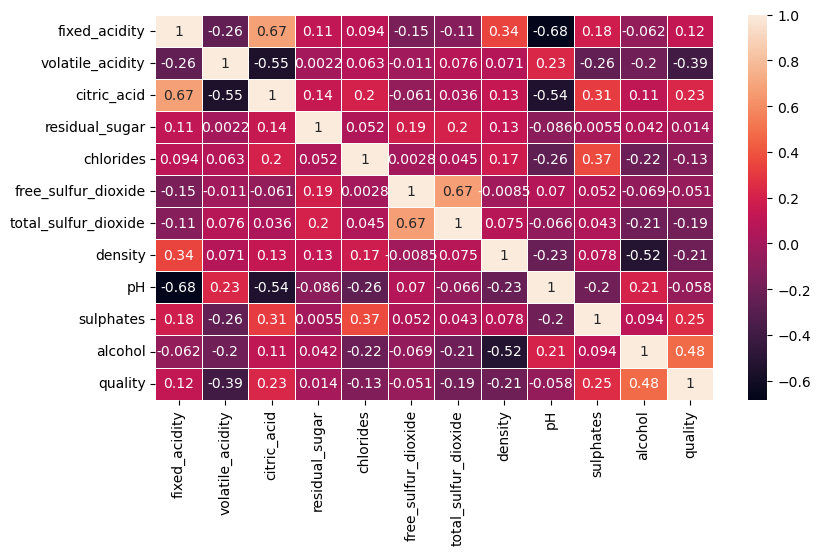

In [11]:
#Let's start with a heatmap
plt.figure(figsize=(9,5))
sns.heatmap(red_wine.corr(), annot=True, linewidth=0.5)

## Heatmap Analysis

## A value near zero means there is no correlation between the column and row. 

###  fixed_acidity - No correlation with wine quality (No Correlation)
###  volatile_acidity - As Acidity goes down, wine quality rises for the most part (Medium Correlation)
###  citric_acid - As Citric Acid rises, wine quality rises (Medium Correlation)
###  residual_sugar - No real correlation, the level of residual sugar does not seem to impact quality (no Correlation)
###  chlorides - As Clorides goes down, wine quality rises (low Correlation)
###  free_sulfur_dioxide - No correlation with wine quality (no Correlation) 
###  total_sulfur_dioxide - As Total Sulfur Dioxide goes down, there is a small correlation with wine quality (low Correlation)
###  density - As Density falls, small correlation with wine quality (low Correlation)
###  pH - No correlation, wine quality improves (No Correlation)
###  sulphates - As Sulphates rise, wine quality rises (Medium Correlation)
###  alcohol - As alcohol rises, wine quality rises (High Correlation)


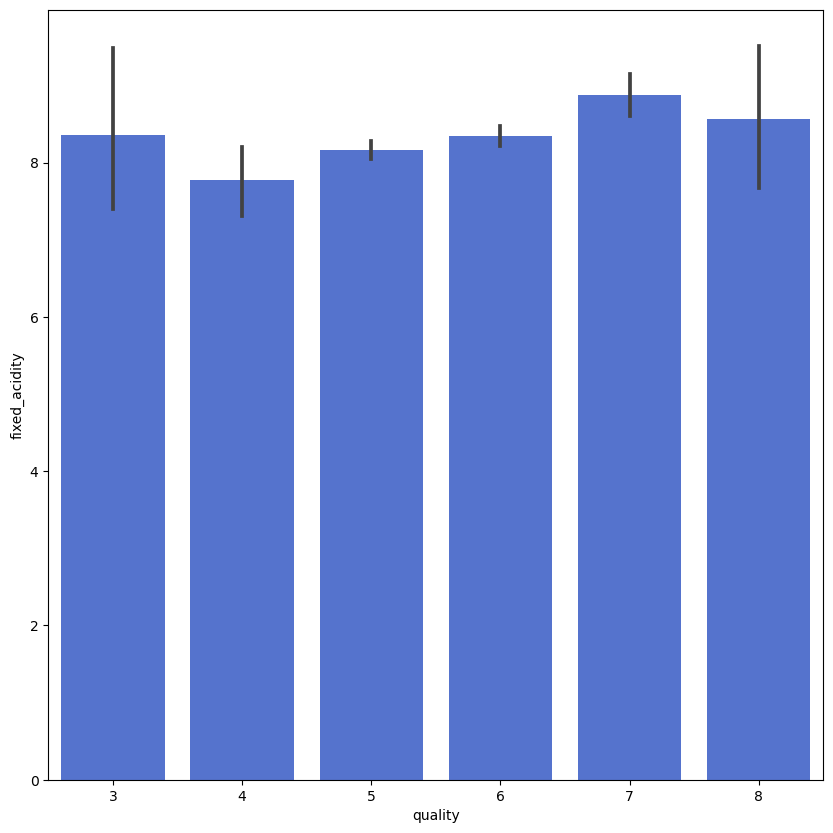

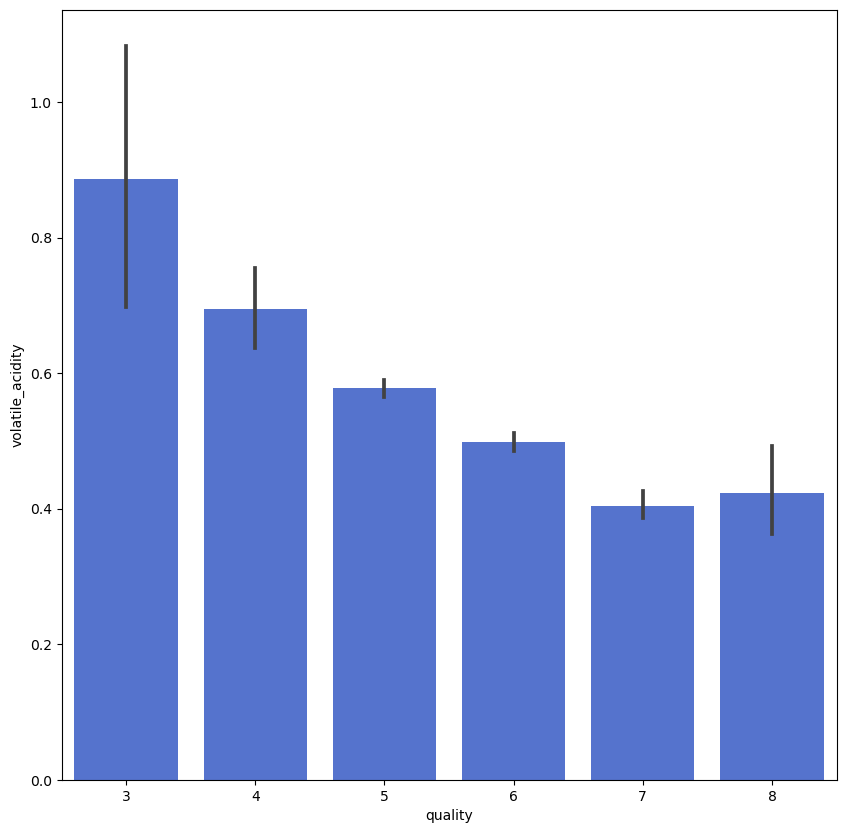

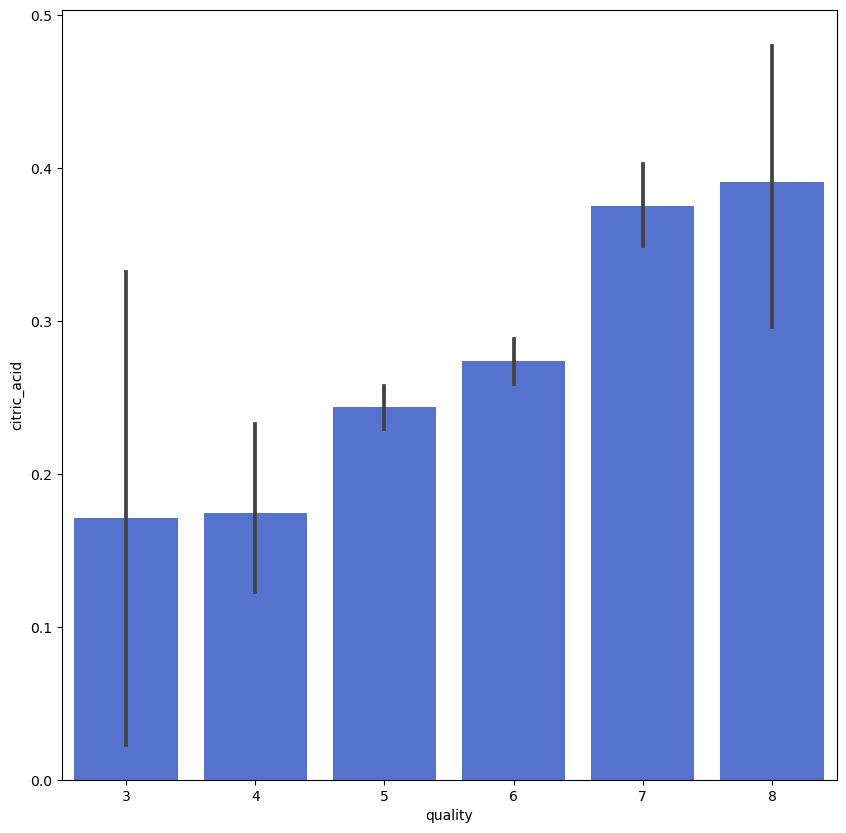

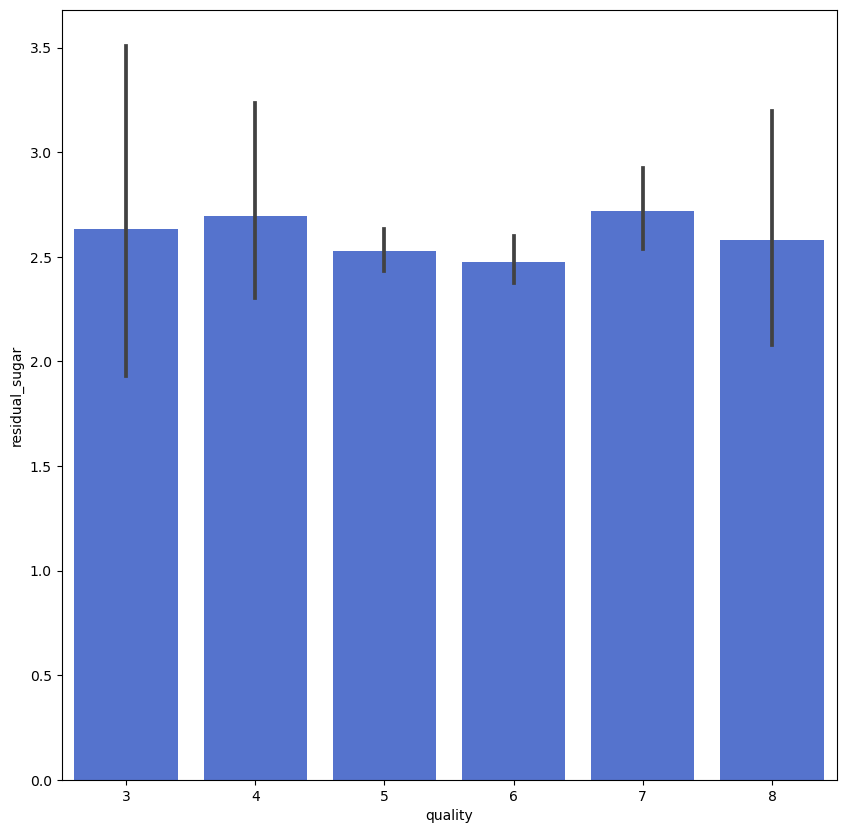

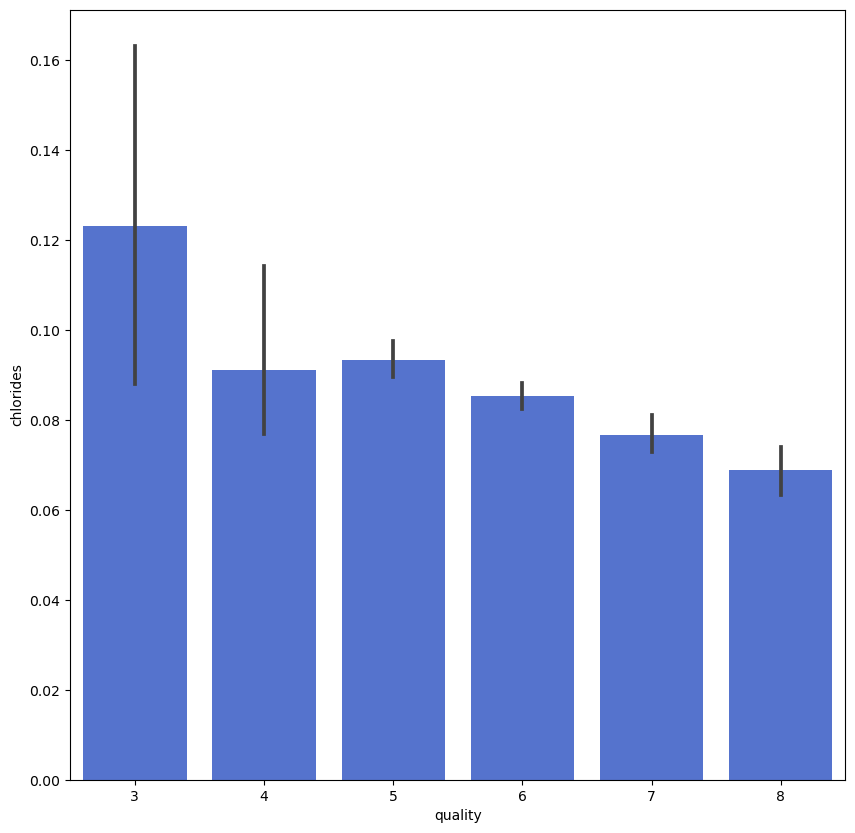

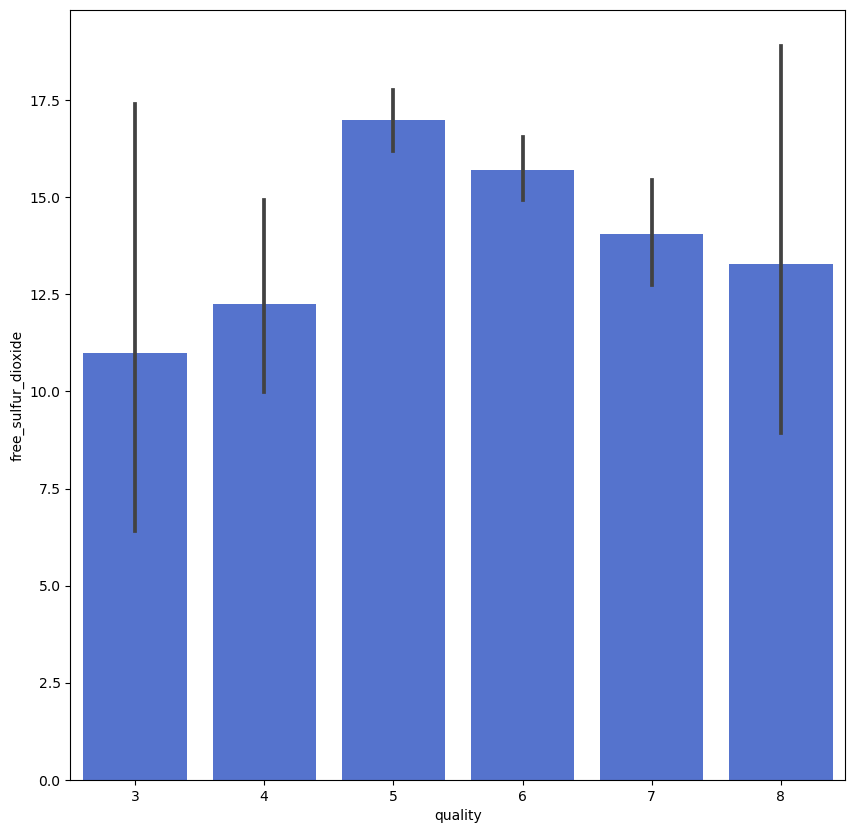

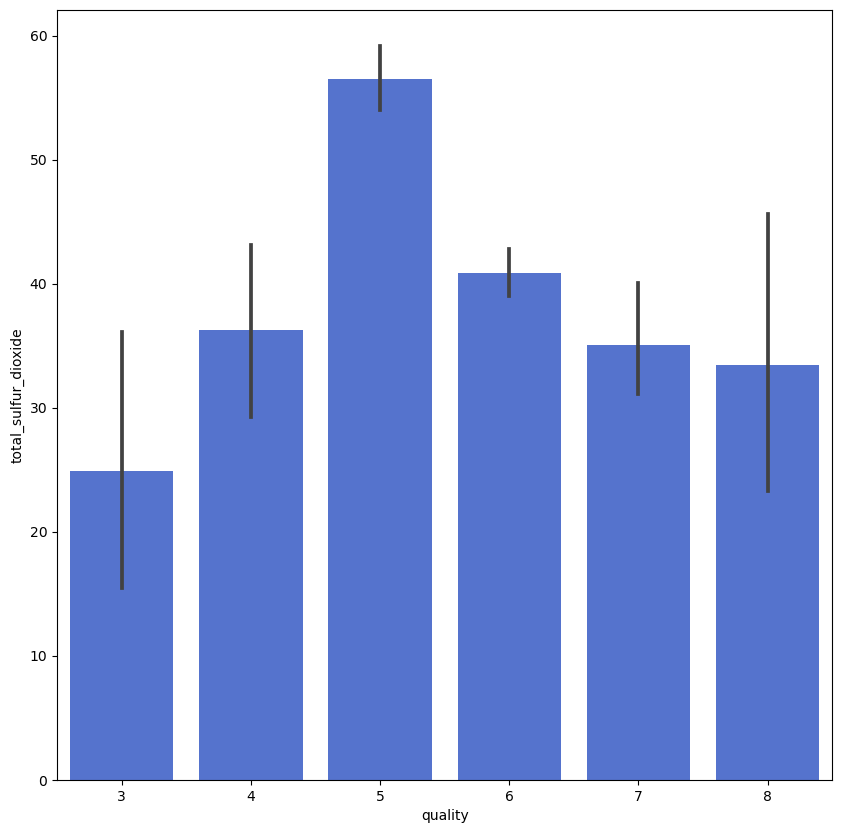

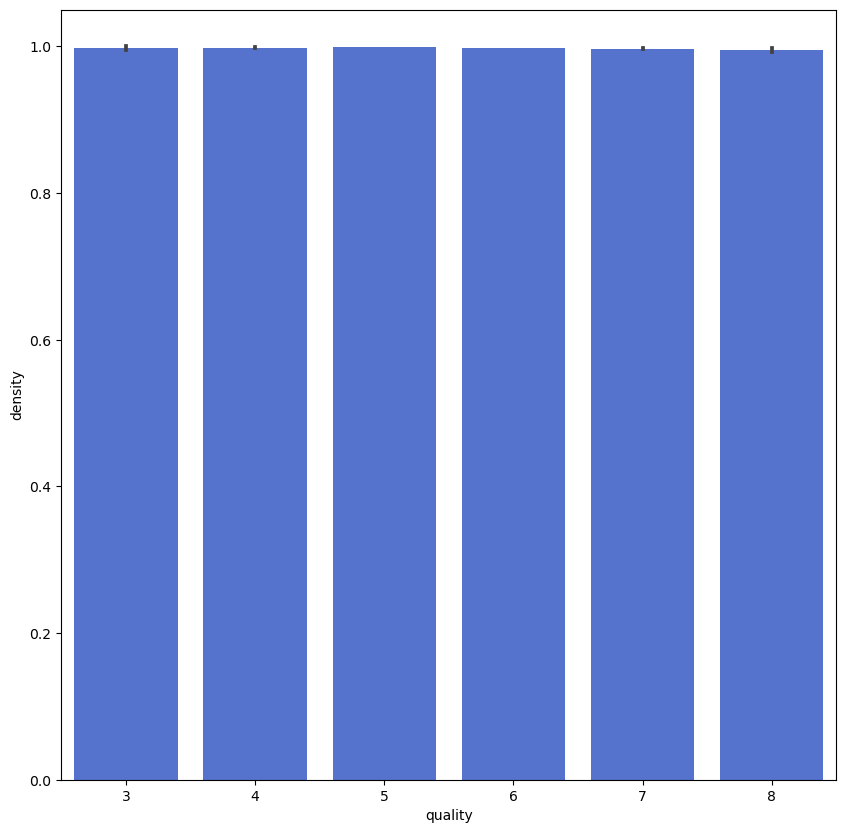

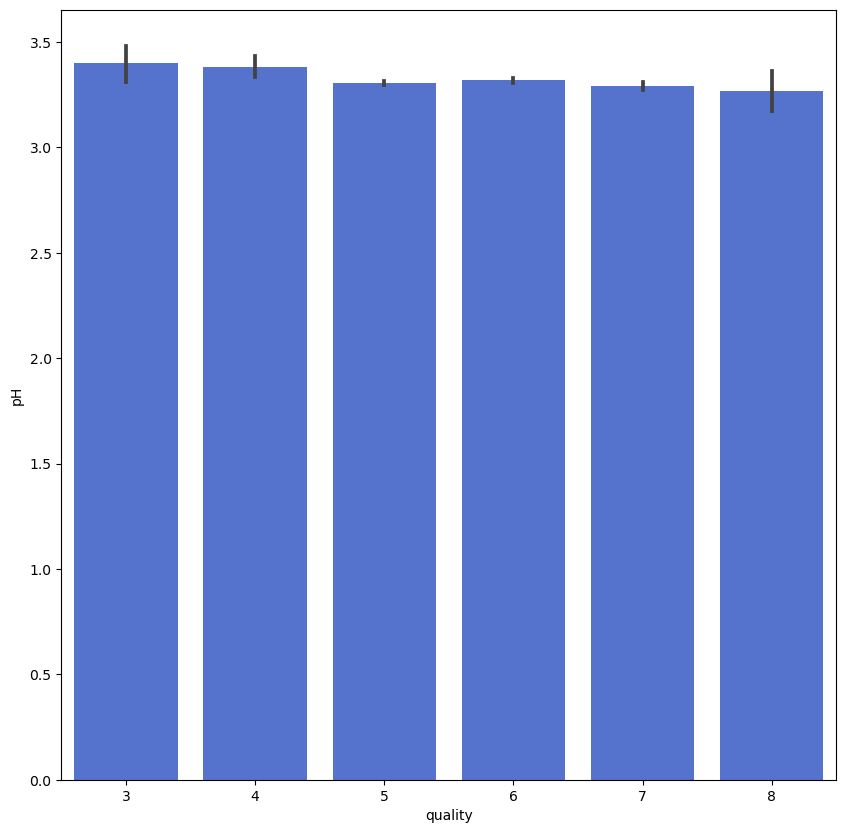

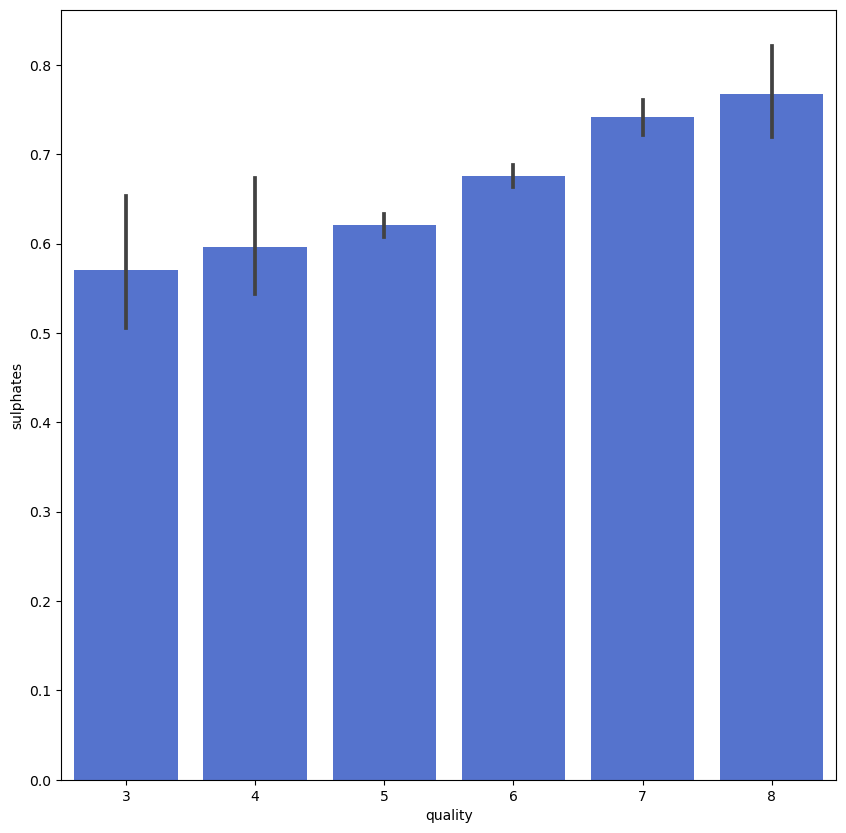

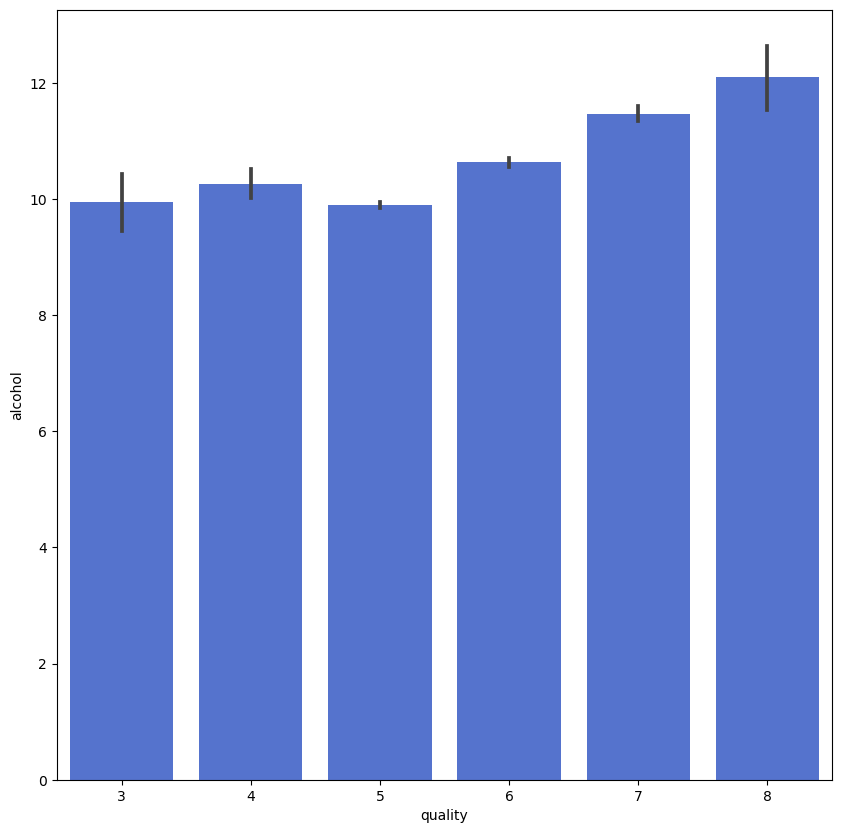

In [12]:
index=0
labels = red_wine['quality']
features = red_wine.drop('quality', axis=1)

for col in features.items():
    plt.figure(figsize=(10,10))
    sns.barplot(x=labels, y=col[index], data=red_wine, color="royalblue")
#plt.tight_layout()
plt.show()

## Barplot Analysis

###  fixed_acidity - No correlation with wine quality (No Correlation)
###  volatile_acidity - As Acidity goes down, wine quality rises for the most part (Medium Correlation)
###  citric_acid - As Citric Acid rises, wine quality rises (Medium Correlation)
###  residual_sugar - No real correlation, the level of residual sugar does not seem to impact quality (no Correlation)
###  chlorides - As Clorides goes down, wine quality rises (High Correlation)
###  free_sulfur_dioxide - No correlation with wine quality (No Correlation)
###  total_sulfur_dioxide - No correlation with wine quality (No Correlation)
###  density - No correlation with wine quality (No Correlation)
###  pH - As pH goes down, wine quality improves (Low Correlation)
###  sulphates - As Sulphates rise, wine quality rises (High Correlation)
###  alcohol - As alcohol rises, wine quality rises for the most part (Medium Correlation)

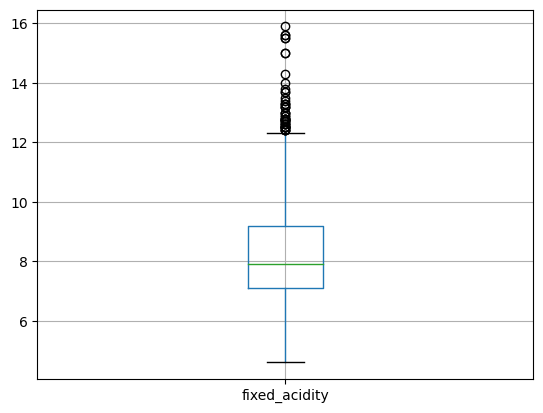

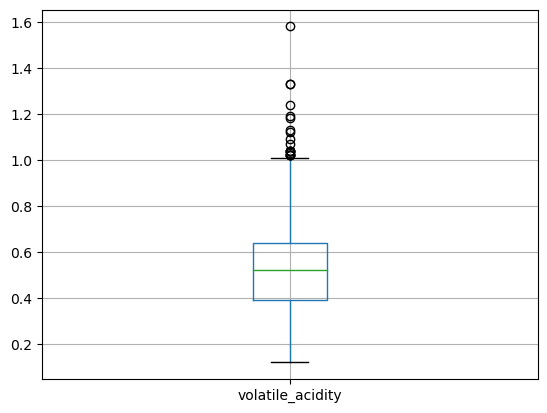

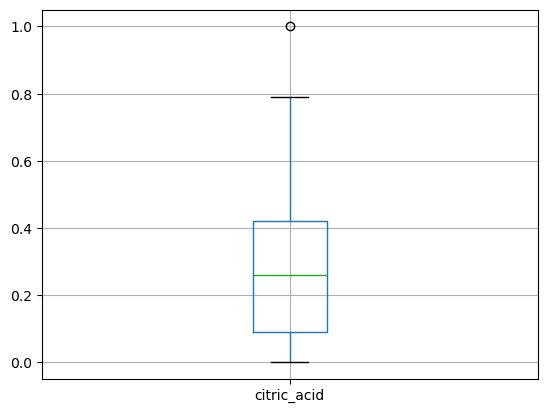

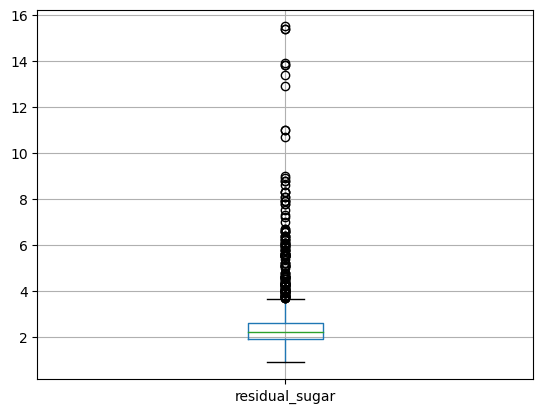

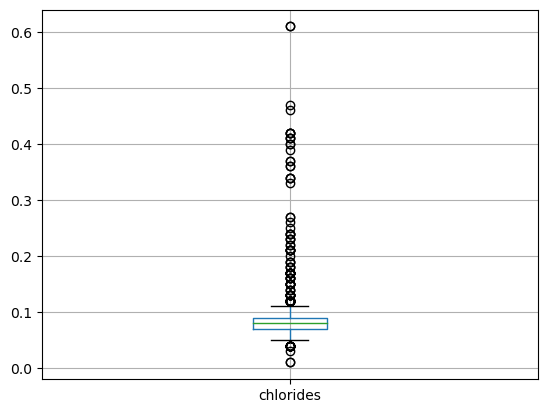

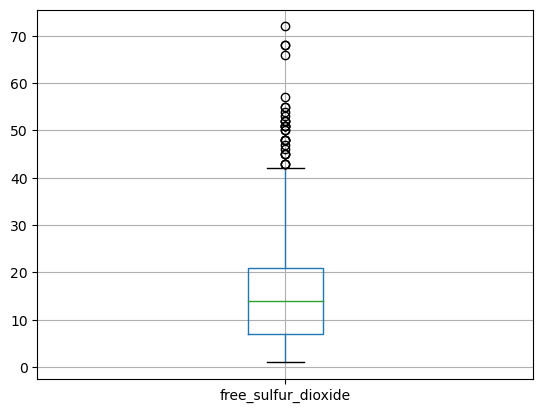

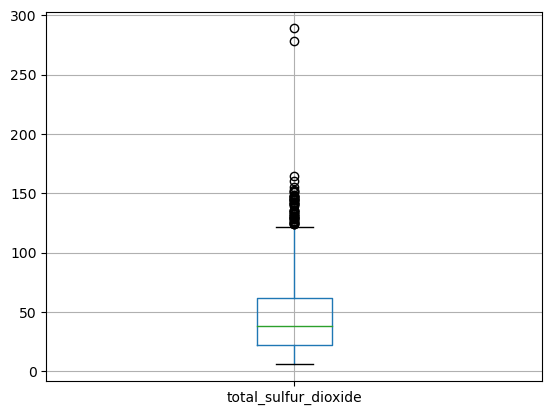

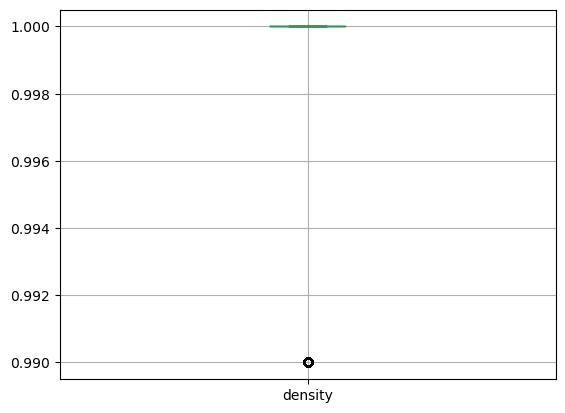

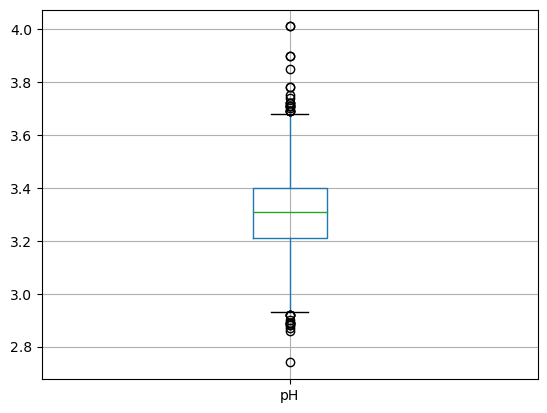

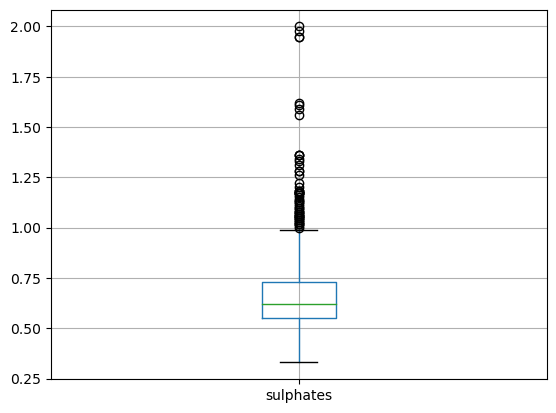

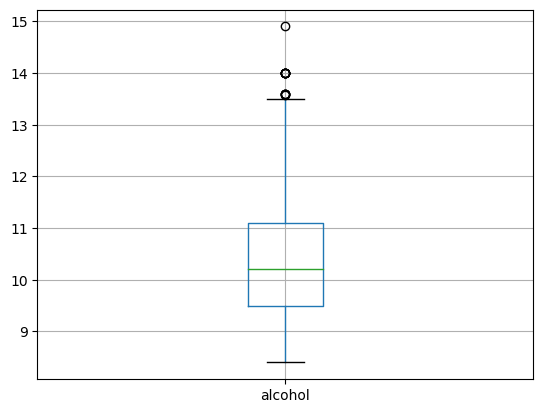

In [13]:
for col in X.items():
    plt.figure()   # plots figure for each iteration
    X.boxplot(column=col[0])

## Boxplot Analysis

###  fixed_acidity - Many outliers above 12
###  volatile_acidity - Everything above 1 is considered an outlier
###  citric_acid - A single outlier at 1
###  residual_sugar - Everything ~3.5 and above are considered outliers
###  chlorides - This has outliers above and below the box plot
###  free_sulfur_dioxide - Everything above 42 is an outlier
###  total_sulfur_dioxide - A cluster around 120 then some above as well
###  density - No outliers
###  pH - A few above and a few below the 3.2 - 3.4 box
###  sulphates - Everything above 1 is considered an outlier
###  alcohol - Everything higher than 13.5 is considered an outlier



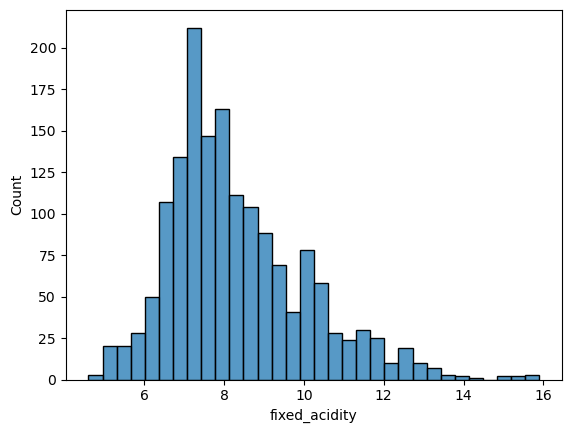

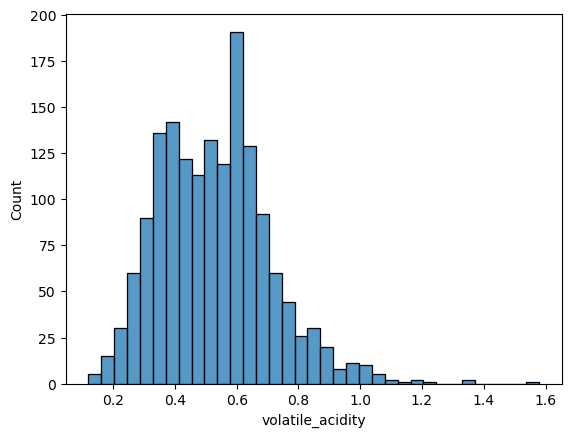

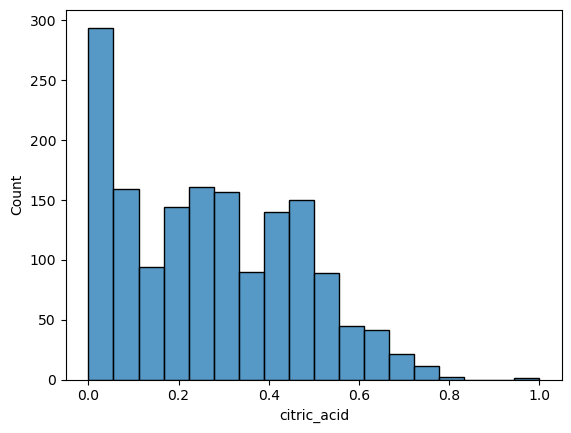

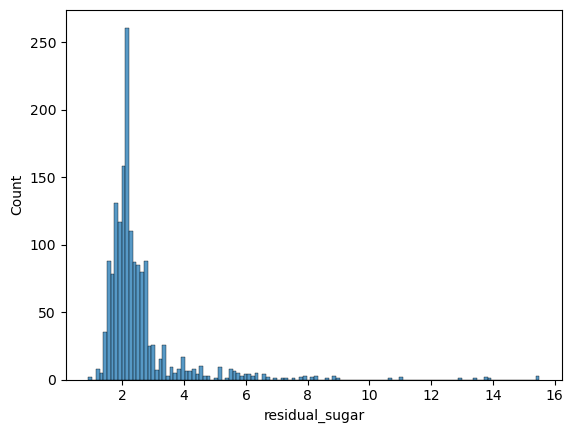

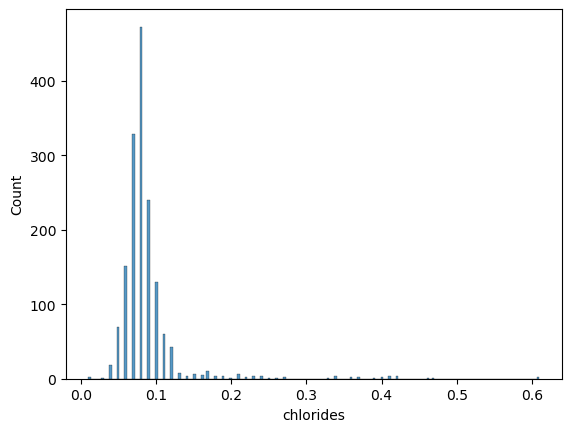

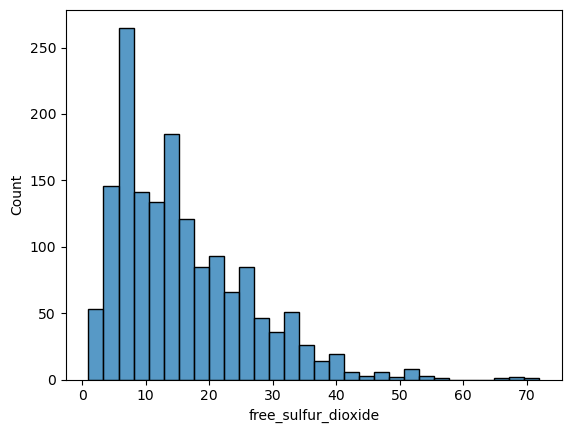

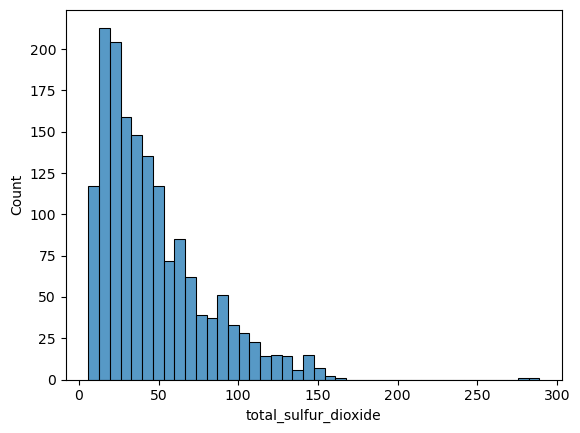

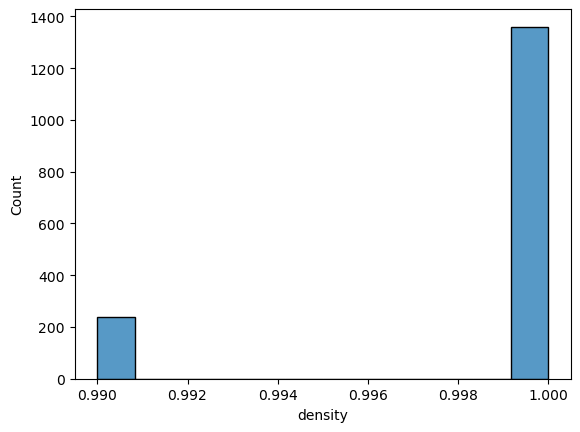

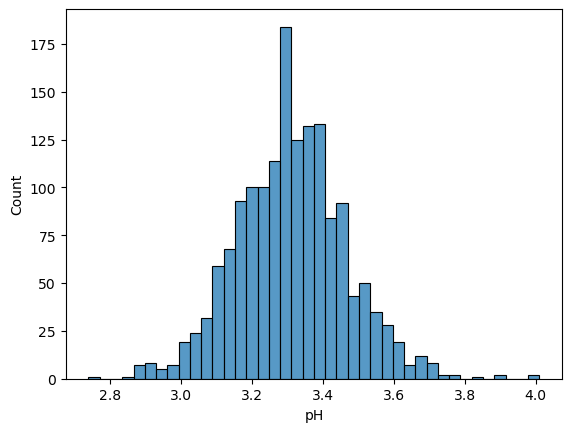

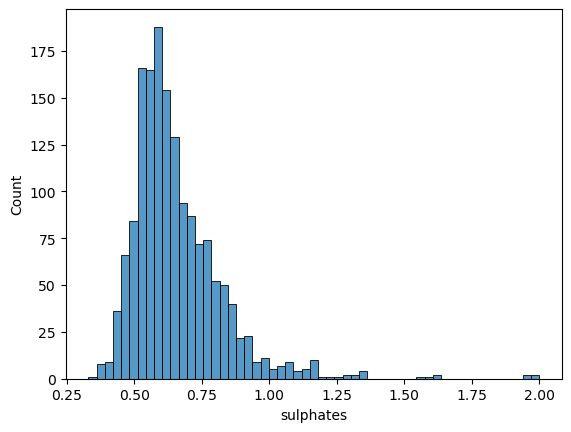

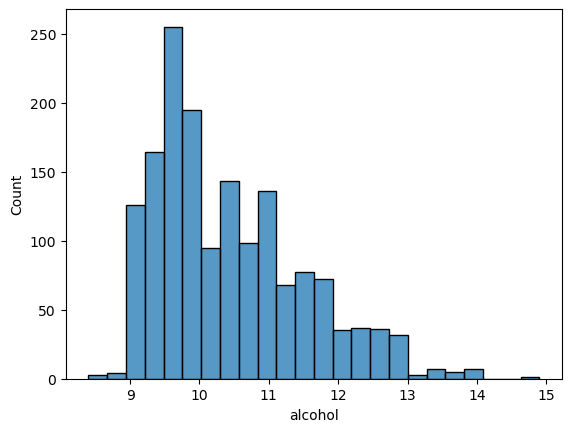

In [14]:
for col in X.items():
    plt.figure()   # plots figure for each iteration    
    sns.histplot(X[col[0]])

# Removing Outliers

## Using the IQR method, we will remove anything not in the range of (Q1 - 1.5 IQR) and (Q3 + 1.5 IQR) because it is an outlier.



In [15]:
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

## Check the skew of the different features. We would like to see the skew values to be between -1.0 and 1.0. Anything higher indicates outliers.

In [16]:
red_wine.skew()

fixed_acidity           0.982751
volatile_acidity        0.671500
citric_acid             0.318337
residual_sugar          4.540655
chlorides               5.643295
free_sulfur_dioxide     1.250567
total_sulfur_dioxide    1.515531
density                -1.968090
pH                      0.193683
sulphates               2.428672
alcohol                 0.860854
quality                 0.217802
dtype: float64

In [17]:
red_wine_out = red_wine[~((red_wine < (Q1 - 1.5 * IQR)) | (red_wine > (Q3 + 1.5 * IQR))).any(axis=1)]
print(red_wine_out.shape)

(998, 12)


## This method removed 601 rows or 37.5% of the data. As you will see below, the skew of the features are all within a good range.

In [18]:
red_wine_out.skew()

fixed_acidity           0.776929
volatile_acidity        0.269548
citric_acid             0.300759
residual_sugar          0.628895
chlorides               0.154649
free_sulfur_dioxide     0.855645
total_sulfur_dioxide    0.910651
density                 0.000000
pH                      0.035459
sulphates               0.706068
alcohol                 0.921152
quality                 0.326204
dtype: float64

<hr style="border:2px solid blue">

# Let's set up the model, we will use Random Forest first

In [19]:
# Checking model Random Forest and choosing hyperparameters
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=32)

In [20]:
# First time through we will leave the default parameters in place
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 32,
 'verbose': 0,
 'warm_start': False}

In [21]:
# Fit the model to the training data (this is where the model figures out the patterns)
# The model is attempting to figure out the relationship between the features and the labels
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)


In [22]:
clf.fit(X_train, y_train);
clf.score(X_train, y_train)

1.0

In [23]:
print(f'{clf.score(X_test, y_test) * 100}%')

71.5625%


### As you can see, the score for the training model is 100%, this is expected because it has the labels to correct itself. The test score on the other hand is 71% for which tells me we should probably correct the outliers in the data. 

In [24]:
y_preds = clf.predict(X_test)


In [25]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        14
           5       0.78      0.80      0.79       134
           6       0.68      0.77      0.72       128
           7       0.64      0.59      0.61        39
           8       0.00      0.00      0.00         3

    accuracy                           0.72       320
   macro avg       0.35      0.36      0.35       320
weighted avg       0.67      0.72      0.69       320



In [26]:
print(confusion_matrix(y_test, y_preds))

[[  0   0   2   0   0   0]
 [  0   0   7   6   1   0]
 [  0   0 107  25   2   0]
 [  0   0  21  99   8   0]
 [  0   0   1  15  23   0]
 [  0   0   0   1   2   0]]


## Now let's try the model again with the cleaned data 

In [27]:
clf_out = RandomForestClassifier(random_state=32)

# Create X for the Red Wines
X_out = red_wine_out.drop("quality", axis=1)

# Create y (labels)
y_out = red_wine_out["quality"]

In [28]:
# Fit the model to the training data (this is where the model figures out the patterns)
# The model is attempting to figure out the relationship between the features and the labels
X_out_train, X_out_test, y_out_train, y_out_test = train_test_split(X_out, y_out, test_size=0.2, random_state=68)

In [29]:
clf_out.fit(X_out_train, y_out_train);
clf_out.score(X_out_train, y_out_train)

1.0

In [30]:
print(f'{clf_out.score(X_out_test, y_out_test) * 100}%')

71.0%


### Cleaning the data didn't help with the classification, it made it a bit worse. 

## Let's try changing the hyperparameters on the original data. We will try different values of n_estimator

In [31]:
np.random.seed(28)
for i in range(10,100,10):
    print(f'Setting n_estimator to {i} and testing model')
    test_model = RandomForestClassifier(n_estimators=i, random_state=32).fit(X_train, y_train)
    print(f'Model accuracy with this n_estimator - {test_model.score(X_test, y_test)* 100}%\n')

Setting n_estimator to 10 and testing model
Model accuracy with this n_estimator - 69.0625%

Setting n_estimator to 20 and testing model
Model accuracy with this n_estimator - 70.3125%

Setting n_estimator to 30 and testing model
Model accuracy with this n_estimator - 71.25%

Setting n_estimator to 40 and testing model
Model accuracy with this n_estimator - 73.4375%

Setting n_estimator to 50 and testing model
Model accuracy with this n_estimator - 72.5%

Setting n_estimator to 60 and testing model
Model accuracy with this n_estimator - 72.5%

Setting n_estimator to 70 and testing model
Model accuracy with this n_estimator - 73.125%

Setting n_estimator to 80 and testing model
Model accuracy with this n_estimator - 72.8125%

Setting n_estimator to 90 and testing model
Model accuracy with this n_estimator - 73.125%



## It looks like n_estimator '40' gives the best results. We will now move on to the ACC model

In [32]:
from sklearn.neural_network import MLPClassifier

clf_acc = MLPClassifier(random_state=32)

In [33]:
# Create X for the Red Wines
X_acc = red_wine.drop("quality", axis=1)

# Create y (labels)
y_acc = red_wine["quality"]

In [34]:
X_acc_train, X_acc_test, y_acc_train, y_acc_test = train_test_split(X_acc, y_acc, test_size=0.2, random_state=32)

In [35]:
clf_acc.fit(X_acc_train, y_acc_train)                                                                    
clf_acc.score(X_acc_train, y_acc_train)
                                                                    

0.5840500390930414

## That was really low, I want to try one more I have had success with before which is the Support Vector Classifier

In [36]:
from sklearn.svm import SVC
clf_svc = SVC(random_state=32)

In [37]:
# Create X for the Red Wines
X_svc = red_wine.drop("quality", axis=1)

# Create y (labels)
y_svc = red_wine["quality"]

In [38]:
X_svc_train, X_svc_test, y_svc_train, y_svc_test = train_test_split(X_svc, y_svc, test_size=0.2, random_state=32)

In [39]:
clf_svc.fit(X_svc_train, y_svc_train)                                                                    
clf_svc.score(X_svc_train, y_svc_train)

0.509773260359656

## That was even worse, barely better than a coin toss. 

## The final model that we will use is the Random Forest with a n_estimator of '40'

In [40]:
test_model = RandomForestClassifier(n_estimators=40, random_state=32).fit(X_train, y_train)

In [41]:
import pickle

# Save our model to file
pickle.dump(test_model, open("random_forest_model_1.pkl", "wb"))

In [42]:
# Make sure we can use the model again
loaded_model = pickle.load(open("random_forest_model_1.pkl", "rb"))
loaded_model.score(X_test, y_test)

0.734375

## Verified that this is the same score as previously.


## The Modeling section is complete, and below we will create a test form that will use our model to make predictions based upon entered data


<br><br><br>

<hr style="border:5px solid blue">

# Everything Below is for our application page

<hr style="border:5px solid blue">

## Display an Image of red grapes

In [43]:
file = open("images/grapes.jpeg", "rb")
image = file.read()

image_headline = widgets.Image(value=image, format='jpeg', width='300')

label_headline = widgets.Label(value='Red Grapes', style={'description_width': 'initial'})

vbox_headline = widgets.VBox([image_headline, label_headline])

## The settings below apply to the Float Slider Widgets. This allows their whole label to fit and for all to be the same size

In [44]:
# Setup the label width to fit whatever is in the description
style = {'description_width': 'initial'}

# Setup the width of the entire widget
layout = {'width': '400px'}

# Below we are creating 11 float slider widgets, these allow us to set the min and max values, we are using sliders to allow a visual way to change values and see how it improves or decreases the wines rating. The default value is set to the highest Quality rated Red Wine (an 8). This allows the user to change the values and see the quality change as well. 

In [45]:
fixed_acidity = widgets.FloatSlider(
    style=style,
    layout=layout,
    value=12.6,
    min=4.5,
    max=16.0,
    step=0.1,
    description='Fixed Acidity:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

volatile_acidity = widgets.FloatSlider(
    style=style,
    layout=layout,
    value=0.31,
    min=0.1,
    max=1.6,
    step=0.01,
    description='Volatile Acidity:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)


citric_acid = widgets.FloatSlider(
    style=style,
    layout=layout,
    value=0.72,
    min=0.00,
    max=1.00,
    step=0.01,
    description='Citric Acid:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

residual_sugar = widgets.FloatSlider(
    style=style,
    layout=layout,
    value=2.2,
    min=.5,
    max=16.0,
    step=0.1,
    description='Residual Sugar:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

chlorides = widgets.FloatSlider(
    style=style,
    layout=layout,
    value=0.07,
    min=0.,
    max=0.70,
    step=0.01,
    description='Chlorides:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

free_sulfur_dioxide = widgets.FloatSlider(
    style=style,
    layout=layout,
    value=6.0,
    min=1.0,
    max=75.0,
    step=1,
    description='Free Sulfur Dioxide:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

total_sulfur_dioxide = widgets.FloatSlider(
    style=style,
    layout=layout,
    value=29.,
    min=1.,
    max=300.,
    step=1.,
    description='Total Sulfur Dioxide:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

density = widgets.FloatSlider(
    style=style,
    layout=layout,
    value=1.,
    min=.99,
    max=1.0,
    step=0.01,
    description='Density:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

pH = widgets.FloatSlider(
    style=style,
    layout=layout,
    value=2.88,
    min=2.5,
    max=4.1,
    step=0.01,
    description='pH:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

sulphates = widgets.FloatSlider(
    style=style,
    layout=layout,
    value=0.82,
    min=0.3,
    max=2.0,
    step=0.01,
    description='Sulphates:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

alcohol = widgets.FloatSlider(
    style=style,
    layout=layout,
    value=9.8,
    min=8.,
    max=15.0,
    step=0.1,
    description='Alcohol:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

# This button will gather the values from the slider and run it against the red model and return a prediction on the wine's quality

In [46]:
button_send = widgets.Button(description='Calculate Wine Rating', tooltip='Calculate Wine Rating', style=style, layout=layout)

output = widgets.Output()

def on_button_clicked(event):
    with output:
        clear_output()
        df = pd.DataFrame([np.array([fixed_acidity.value, volatile_acidity.value, citric_acid.value, residual_sugar.value, chlorides.value, free_sulfur_dioxide.value, total_sulfur_dioxide.value, density.value, pH.value, sulphates.value, alcohol.value])], columns = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol'])
        print(f"This Red Wine with the values of:")
        print(f"Fixed Acidity: {fixed_acidity.value}, Volatile Acidity: {volatile_acidity.value}")
        print(f"Citric Acid: {citric_acid.value}, Residual Sugar: {residual_sugar.value}, Chlorides: {chlorides.value}")
        print(f"Free Sulfur Dioxide: {free_sulfur_dioxide.value}, Total Sulfur Dioxide: {total_sulfur_dioxide.value}") 
        print(f"Density: {density.value}, pH: {pH.value}, Sulphates: {sulphates.value}, Alcohol: {alcohol.value}")
        print("Has a predicted rating of:")
        prediction =  test_model.predict(df)
        display(Markdown('# {}'.format(prediction)))

button_send.on_click(on_button_clicked)

vbox_result = widgets.VBox([button_send, output])

## Display the page we have designed 

In [47]:
vbox_text = widgets.VBox([fixed_acidity, volatile_acidity, citric_acid, residual_sugar, chlorides, free_sulfur_dioxide, total_sulfur_dioxide, density, pH, sulphates, alcohol, vbox_result])


page = widgets.HBox([vbox_headline, vbox_text])
display(page)